In [1]:
using  Plots, Optim, Dates, DiffEqParamEstim, Flux, DiffEqFlux, OrdinaryDiffEq

In [121]:

x = -[180.,180.5,181.,181.5,182,183,184,184.5,185,185.5,186,186.,187,187.5,188,188.1,188.3,188.1,188,188.1,188.2,188.1,188.1,188.2,188.1,188.1,188.2,188.1,188,188,188.1,188.2,188.1,188,187.5,187.,186.5,186,185.5,185,184.5,184,183.5,183.,182.5,182,181.1,181,180.5,180.1,179.8,179.9,180,180.1,180.5,180.1,179.8,180.5,180.1,179.8,179.9,180,180.1,180.2,180.3,180.5,180.1,179.8,179.9,180,180.1,180.2,180.3,180.2,180.3,180.2,180.3,180.6,181,181.5,182,182.5,184,184.5,185,185.5, 186,186.5,187,187.5,188,188.1]

st = length(x)
ode_data = transpose(hcat(x[1:st]))
u0 = [x[1]]
tspan = (0.0f0, 3.f0)
t = range(tspan[1], tspan[2], length = st)
species1 = "BPM"

"BPM"

In [122]:
ode_data

1×92 LinearAlgebra.Transpose{Float64,Array{Float64,2}}:
 -180.0  -180.5  -181.0  -181.5  -182.0  …  -187.0  -187.5  -188.0  -188.1

In [123]:
mutable struct saver
    losses::Array{Float64,1}
    l2s::Array{Float64,1}
    times::Array{Dates.Time,1}
    count_epochs::Int128
end
function saver(n_epochs)
    losses = zeros(n_epochs)
    l2s = zeros(n_epochs)
    times = fill(Dates.Time(Dates.now()),n_epochs)
    count_epochs = 0
    return saver(losses,l2s,times,count_epochs)
end
function update_saver(saver, loss_i, l2_i, time_i)
    epoch_i = saver.count_epochs
    saver.losses[epoch_i] = loss_i
    saver.l2s[epoch_i] = l2_i
    saver.times[epoch_i] = time_i
end

update_saver (generic function with 1 method)

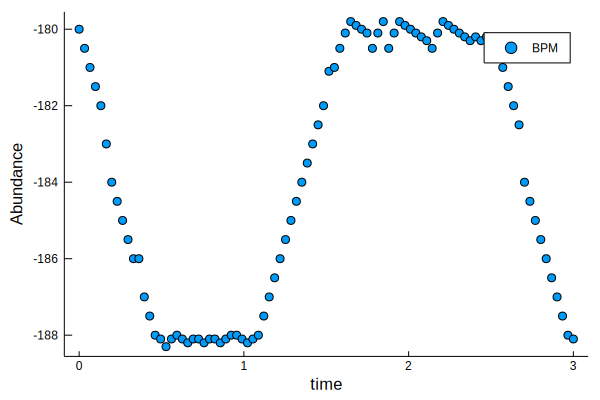

In [124]:
scatter(t, ode_data[1,:], grid = "off", xlab = "time", ylab = "Abundance", label = species1)

In [130]:
# Building a neural ODE 
# Derivative is modeled by a neural net. Chain concatinates the functions ode function and two dense layers.
dudt = Chain(Dense(1,500,tanh),
       Dense(500,500,tanh),
        Dense(500,500,tanh),
       Dense(500,1))
# Parameters of the model which are to be learnt. They are: W1 (2x50), b1 (50), W2 (50x2), b2 (2)
ps = Flux.params(dudt)
# Getting loss function from two stage collocation function
function node_two_stage_function(model, x, tspan, saveat, ode_data,
            args...; kwargs...)
  dudt_(du,u,p,t) = du .= model(u)
  prob_fly = ODEProblem(dudt_,x,tspan)
  two_stage_method(prob_fly, saveat, ode_data)
end
loss_n_ode = node_two_stage_function(dudt, u0, tspan, t, ode_data, Tsit5(), reltol=1e-7, abstol=1e-9)
#  loss function
two_stage_loss_fct()=loss_n_ode.cost_function(ps)
# Defining anonymous function for the neural ODE with the model. in: u0, out: solution with current params.
n_ode = x->neural_ode(dudt, x, tspan, Tsit5(), saveat=t, reltol=1e-7, abstol=1e-9)
n_epochs = 24000
verify = 500 # for <verify>th epoch the L2 is calculated  
data1 = Iterators.repeated((), n_epochs)
opt1 = ADAM(0.0001)
sa = saver(n_epochs)
L2_loss_fct() = sum(abs2,ode_data .- n_ode(u0))
# Callback function to observe two stage training.
cb1 = function ()
    sa.count_epochs = sa.count_epochs +  1
    if mod(sa.count_epochs-1, verify)==0
        update_saver(sa, Tracker.data(two_stage_loss_fct()),Tracker.data(L2_loss_fct()), Dates.Time(Dates.now()))
        # println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    else
        update_saver(sa, Tracker.data(two_stage_loss_fct()),0,Dates.Time(Dates.now()))
        # println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    end
end


#109 (generic function with 1 method)

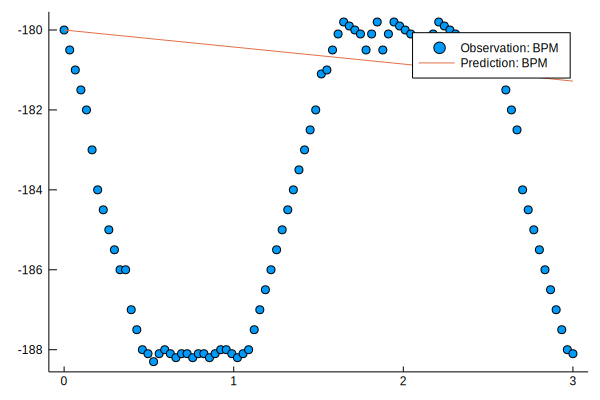

In [131]:
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))

In [ ]:
# train n_ode with collocation method
@time Flux.train!(two_stage_loss_fct, ps, data1, opt1, cb = cb1)

In [ ]:
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = string("Observation "), grid = "off")
plot!(t, Flux.data(pred[1,:]), label = string("Prediction "))

In [ ]:
header = string("col losses: ", sa.times[end] - sa.times[1])
scatter(range(1,stop=length(sa.l2s)),log.(sa.l2s),width  =2, label = "l2s", grid = "off")
plot!(range(1,stop=length(sa.losses)),log.(sa.losses), width  =2, label = header)
# 5% of time even with l2s